# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [1]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [3]:
ds_train = pd.read_csv("C:/Users/marti/dmeyf2023/src/datasets/datasets_competencia_02_v01.csv.gz", compression="gzip")
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [5]:
ds_bajas = ds_train.query("clase_ternaria != 'CONTINUA'")

#ds_train_var_drop = ds_train[:,("clase_ternaria", "numero_de_cliente", "foto_mes")]
#ds_bajas_var_drop = ds_bajas[:,("clase_ternaria", "numero_de_cliente", "foto_mes")]

ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente", "foto_mes"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente", "foto_mes"], axis=1)

Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [6]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.0697683730302378,
    'verbose': 2,
    'max_bin': 31,
    'min_data_in_leaf': 683,
    'verbose': 0,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)



Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [7]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia.head(20)


,Features,Importances
111,Visa_fultimo_cierre,388
94,Master_fultimo_cierre,218
137,pasivos_total,189
155,lag3_pasivos_total,151
154,lag1_pasivos_total,135
82,cmobile_app_trx,107
147,lag6_tc_mconsumo_total,92
171,lag6_internet,90
156,lag6_pasivos_total,67
146,lag3_tc_mconsumo_total,64


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [9]:
p_0 = 0.95
print(sum(p_bajas>p_0)/len(p_bajas)*100)
print(sum(p_bajas>p_0))

81.8143416218809
300203


In [10]:
explainer = shap.TreeExplainer(gbm)

shap_values = explainer.shap_values(ds_bajas[p_bajas>p_0])
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas[p_bajas>p_0].columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [11]:
# busco un caso en p_bajas, con un p alta, y tomo su indice
cliente_idx = 1
print(p_bajas[cliente_idx])
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

0.9730638824152185


,18,1
pasivos_total,0.850772,0.136417
lag3_tc_pagado_total,0.909341,0.125297
flujos_ingresos_total,0.773945,0.112577
cpayroll_trx,2.000000,0.061743
ctrx_quarter,73.000000,0.061195
...,...,...
chomebanking_tr_min6,60.000000,-0.458716
Visa_fultimo_cierre,10.000000,-0.872421
lag6_pasivos_total,0.000006,-1.329791
lag1_pasivos_total,0.848953,-1.616104


En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [43]:
shap_bajas.mean().abs().sort_values(ascending=False).head(20)

lag1_pasivos_total          4.456342
lag3_pasivos_total          2.766120
pasivos_total               0.893624
lag6_pasivos_total          0.872770
lag6_internet                         0.693728
Visa_fultimo_cierre                   0.389123
Master_fultimo_cierre                 0.307024
internet                              0.216891
cmobile_app_trx                       0.212470
chomebanking_tr_min6                  0.129195
lag6_tc_pagado_total        0.115595
lag3_internet                         0.095139
lag1_internet                         0.079037
tc_transacciones_total_min6           0.077153
lag3_flujos_ingresos_tot    0.029369
Master_Fvencimiento                   0.028374
tc_mconsumo_total           0.018506
lag6_flujos_ingresos_tot    0.017496
Visa_mconsumosdolares                 0.017367
ctrx_quarter                          0.016139
dtype: float64

La librería contiene útiles herramientas para vizualizar la info anterior

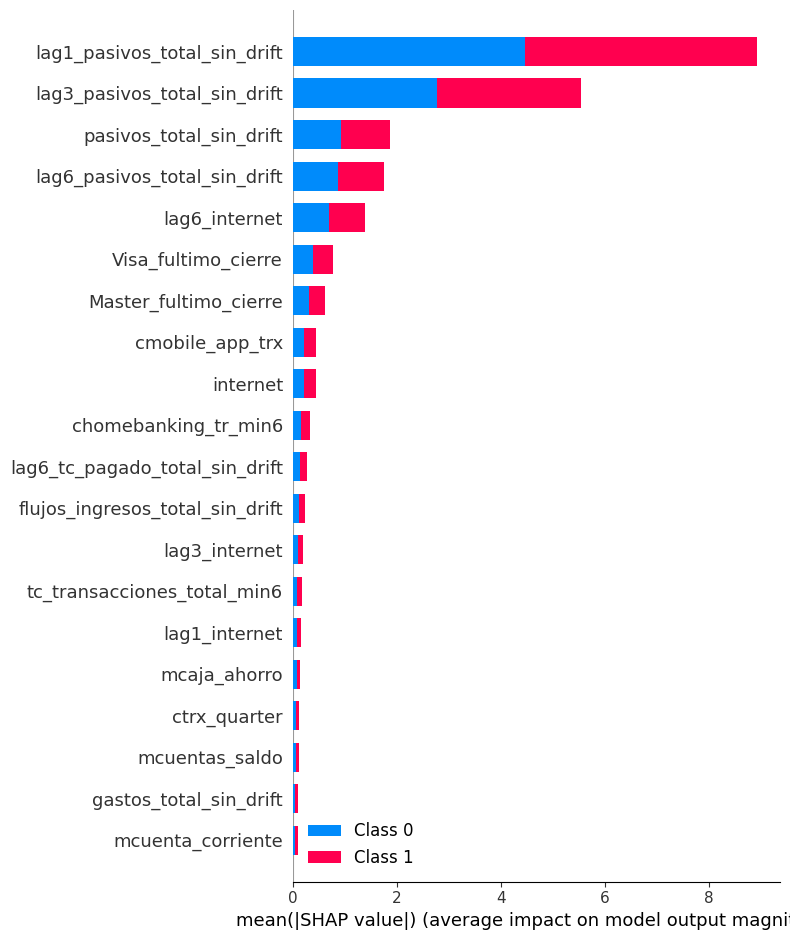

In [13]:
shap.summary_plot(shap_values, ds_bajas[p_bajas>p_0])

Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

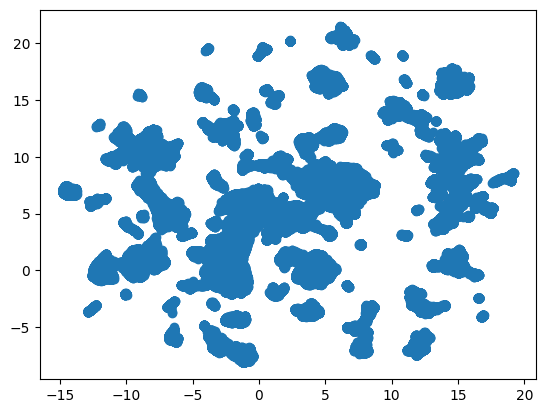

In [14]:
embedding_2d = UMAP(n_components=2, n_neighbors=40).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

(array([   303.,    311.,    338.,    330.,    344.,    324.,    323.,
           380.,    394.,    344.,    383.,    389.,    373.,    367.,
           412.,    444.,    464.,    458.,    403.,    432.,    490.,
           529.,    528.,    583.,    576.,    670.,    582.,    684.,
           704.,    797.,    833.,    908.,    940.,   1014.,   1153.,
          1221.,   1419.,   1611.,   1895.,   2100.,   2322.,   2757.,
          3062.,   3353.,   3618.,   3866.,   4684.,   6133.,   9883.,
        233772.]),
 array([0.95000271, 0.95099098, 0.95197925, 0.95296753, 0.9539558 ,
        0.95494408, 0.95593235, 0.95692063, 0.9579089 , 0.95889717,
        0.95988545, 0.96087372, 0.961862  , 0.96285027, 0.96383855,
        0.96482682, 0.96581509, 0.96680337, 0.96779164, 0.96877992,
        0.96976819, 0.97075646, 0.97174474, 0.97273301, 0.97372129,
        0.97470956, 0.97569784, 0.97668611, 0.97767438, 0.97866266,
        0.97965093, 0.98063921, 0.98162748, 0.98261576, 0.98360403,
        

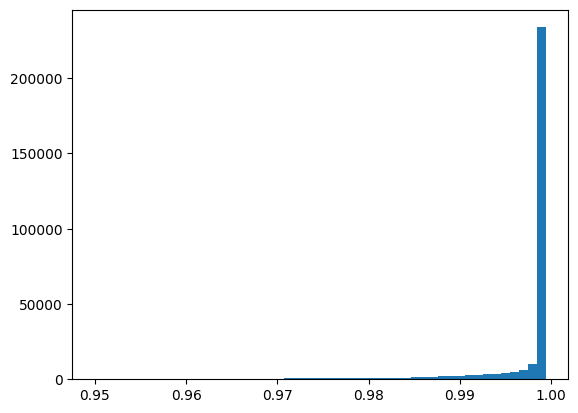

In [17]:
plt.hist(p_bajas[p_bajas>p_0],bins=50)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

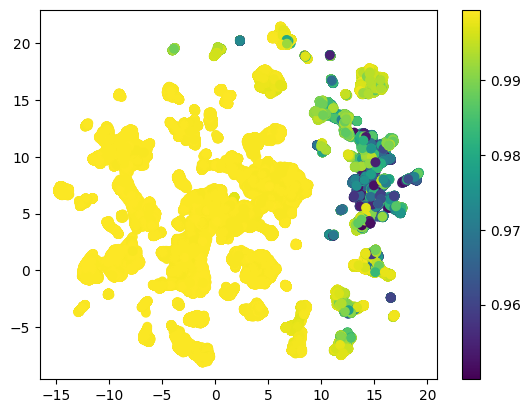

In [18]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas[p_bajas>p_0])
#sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()

Estimated number of clusters: 29
Estimated number of noise points: 9025


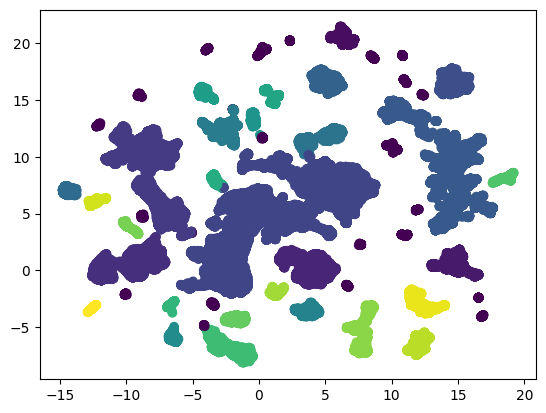

In [19]:

hdb = DBSCAN(eps=0.90, min_samples=1000) # juegue con los parámetros , leaf_size=30
y = hdb.fit(embedding_2d)
#y = hdb.fit(embedding_2d)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(y.labels_)) - (1 if -1 in y.labels_ else 0)
print("Estimated number of clusters: %d" % n_clusters_)

n_noise_ = list(y.labels_).count(-1)
print("Estimated number of noise points: %d" % n_noise_)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_)
plt.show()

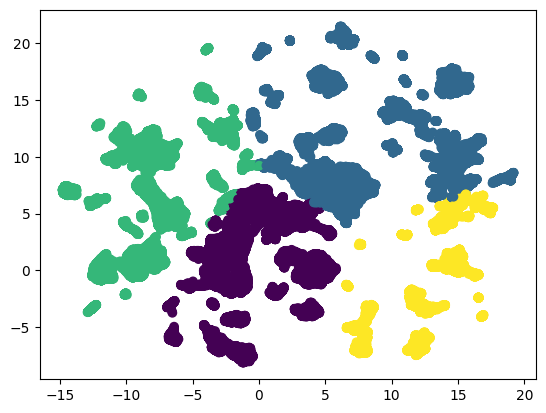

In [99]:
k = 4
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans_umap = kmeans.fit_predict(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=kmeans.labels_)

plt.show()

Comparamos 2 clusters para ver si cambian sus variables importantes

In [86]:
#shap_bajas[kmeans.labels_ == 5].mean().abs().sort_values(ascending=False).head(15)
shap_bajas.mean().abs().sort_values(ascending=False).head(20)

lag1_pasivos_total          4.456342
lag3_pasivos_total          2.766120
pasivos_total               0.893624
lag6_pasivos_total          0.872770
lag6_internet                         0.693728
Visa_fultimo_cierre                   0.389123
Master_fultimo_cierre                 0.307024
internet                              0.216891
cmobile_app_trx                       0.212470
chomebanking_tr_min6                  0.129195
lag6_tc_pagado_total        0.115595
lag3_internet                         0.095139
lag1_internet                         0.079037
tc_transacciones_total_min6           0.077153
lag3_flujos_ingresos_tot    0.029369
Master_Fvencimiento                   0.028374
tc_mconsumo_total           0.018506
lag6_flujos_ingresos_tot    0.017496
Visa_mconsumosdolares                 0.017367
ctrx_quarter                          0.016139
dtype: float64

In [59]:
ds_bajas[p_bajas>p_0][kmeans.labels_ == 4][('internet')].mean()

0.0021993022903079025

In [100]:
import pandas as pd

variables_interes = [
    'active_quarter', 'cliente_vip', 'internet', 'cliente_edad', 'cliente_antiguedad',
    'cproductos','tcuentas','ccaja_seguridad','ccallcenter_transacciones','ctrx_quarter',
    'tmobile_app', 'cmobile_app_trx',
    
    'Master_delinquency','Master_status', 'Visa_delinquency', 'Visa_status',
    
    'tc_mconsumo_total','tc_limcompra_total','tc_pagado_total',
    'pasivos_total','activos_total','flujos_ingresos_total',
    'comisiones_total', 'gastos_total',
    
    'consumo_sobre_ingresos','tcm_consumo_sobre_ingresos','pagado_sobre_ingresos',
    'pagado_sobre_activos','pagomin_sobre_ingresos','gastos_sobre_activos','activos_sobre_pasivos',
    'beneficios_sobre_comisiones','beneficios_sobre_consumos','gastos_sobre_ingresos','lim_sobre_consumos'
                     ]

# Crear un DataFrame para almacenar los promedios por variable y cluster
df_promedios = pd.DataFrame()

# Iterar a través de las variables de interés
for variable in variables_interes:
    # Calcular el promedio de la variable en cada cluster
    promedios = []
    for cluster in range(5):  # Reemplaza num_clusters por el número real de clusters
        promedio = ds_bajas[p_bajas > p_0][kmeans.labels_ == cluster][variable].mean()
        promedios.append(promedio)
    # Agregar la columna de promedios al DataFrame
    df_promedios[variable] = promedios

df_promedios.transpose()

,0,1,2,3,4
active_quarter,0.980608,0.998332,0.988600,0.988607,NaN
cliente_vip,0.005699,0.004993,0.003306,0.000710,NaN
internet,0.012466,0.009501,0.015188,0.058062,NaN
cliente_edad,48.838629,49.184845,43.982859,42.914375,NaN
cliente_antiguedad,138.474775,153.370906,128.765820,100.481862,NaN
cproductos,7.399970,7.876015,7.288555,7.621708,NaN
tcuentas,1.006051,1.001436,1.001929,1.011296,NaN
ccaja_seguridad,0.100921,0.080469,0.055857,0.020720,NaN
ccallcenter_transacciones,0.235643,0.345077,0.248568,0.419023,NaN
ctrx_quarter,111.576785,131.144069,126.724245,119.492770,NaN


Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

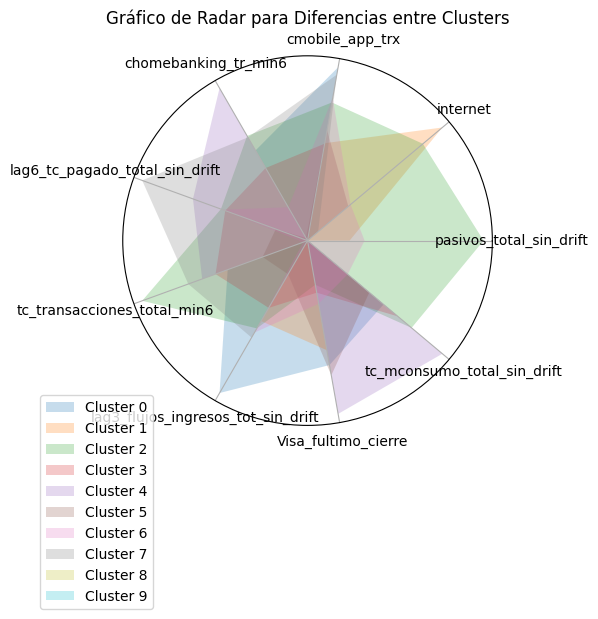

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame df_promedios que contiene los promedios por variable y cluster.
# Asegúrate de que el índice sea el nombre de los clusters.

# Lista de variables de interés (excluyendo la columna "Cluster")
variables_interes = df_promedios.columns.tolist()[:-1]

# Número de variables de interés
num_variables = len(variables_interes)

# Número de clusters
num_clusters = len(df_promedios)

# Crear un DataFrame normalizado para el gráfico de radar
df_normalized = df_promedios.copy()
for variable in variables_interes:
    df_normalized[variable] = (df_normalized[variable] - df_normalized[variable].min()) / (df_normalized[variable].max() - df_normalized[variable].min())

# Ángulos para el gráfico de radar
angles = np.linspace(0, 2 * np.pi, num_variables, endpoint=False).tolist()
angles += angles[:1]

# Crear un gráfico de radar
fig, ax = plt.subplots(subplot_kw={'polar': True})

# Iterar a través de los clusters y dibujar las áreas
for cluster in df_normalized.index:
    values = df_normalized.loc[cluster].tolist()[:-1]
    values += values[:1]
    ax.fill(angles, values, alpha=0.25, label=cluster)

# Etiquetas para cada variable
ax.set_xticks(angles[:-1])
ax.set_xticklabels(variables_interes)
plt.yticks([])

# Leyenda para los clusters
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Título del gráfico
plt.title('Gráfico de Radar para Diferencias entre Clusters')

# Mostrar el gráfico
plt.show()





Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
The figure layout has changed to tight


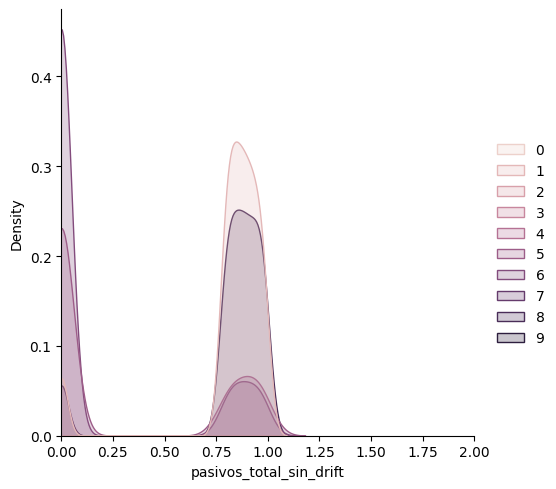

In [32]:
import seaborn as sns 
sns.displot(ds_bajas[p_bajas>p_0], x="pasivos_total",hue=kmeans.labels_ , kind="kde", fill=True).set(xlim=(0, 2))

## Random Forest distance

Veremos otro forma de llegar clusters, pero usando las distancia del Random Forest como input del embedding. Para esto, es necesario primero hacer un RF. No lo haremos con todos los datos, mantendremos todos los **BAJAS** y tan solo algunos continua.

In [ ]:
np.random.seed(17)
continua_sample = clase_train[clase_train == 0].sample(2000).index
bajas_1_2 = clase_train[clase_train == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [ ]:
XRF = ds_train.iloc[rf_index]
yRF = clase_train.iloc[rf_index]

In [ ]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat # transforma de una matriz de proximidad a una de distancia. 


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Y pasamos nuestra matriz de distancia al UMAP

In [ ]:
embedding_rf = UMAP( # Probar parámetros
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1]) # Solo los BAJAS paso... pero no sería interesante pasar todos?

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])